# Laboratory #5_2 : Image Segmentation using UNet

At the end of this laboratory, you would get familiarized with

*   Segmentation using UNet
*   Understand the evaluation metrics
*   Importance of data annotations

**Remember this is a graded exercise.**

*   For every plot, make sure you provide appropriate titles, axis labels, legends, wherever applicable.
*   Create reusable functions where ever possible, so that the code could be reused at different places.
*   Add sufficient comments and explanations wherever necessary.
*   **Once you have the code completed, use GPU to train model faster.**

---

# Loading dataset

*   We will use the [Tray Food Segmentation dataset](https://www.kaggle.com/thezaza102/tray-food-segmentation) for this laboratory.
*   You have two options to get the dataset into your notebook
    *   The dataset is already available in campus virtual. Upload the dataset to your drive before starting the exercise.
    *   You can use the kaggle APIs to get the dataset into the notebook directly (Advanced option).

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Library

In [2]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img
from tensorflow import keras
from PIL.ImageOps import autocontrast
import numpy as np
from tensorflow import keras
from skimage.io import imread
from skimage import io, color
from skimage.transform import resize
from skimage.util import img_as_int
from sklearn.metrics import jaccard_score
import random


# Constants

*   Change the path of the directories according to your drive location.

In [3]:
import os

root_path = r'/content/drive/MyDrive/unet/TrayDataset'

train_img = os.path.join(root_path, 'XTrain')
train_mask = os.path.join(root_path, 'yTrain')
test_img = os.path.join(root_path, 'XTest')
test_mask = os.path.join(root_path, 'yTest')

*   Define the constants needed for training the model

In [4]:
img_size = (160, 160)
num_classes = 43  # fixed for this dataset
batch_size = 32
epochs = 25

# Paths to Input Images and Segmentation Masks

*   We prepare the list of images and masks for both the train and test set

In [5]:
import os

train_img_paths = sorted(
    [
        os.path.join(train_img, fname)
        for fname in os.listdir(train_img)
        if fname.endswith(".jpg") or fname.endswith(".JPG")
    ]
)

train_mask_paths = sorted(
    [
        os.path.join(train_mask, fname)
        for fname in os.listdir(train_mask)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

test_img_paths = sorted(
    [
        os.path.join(test_img, fname)
        for fname in os.listdir(test_img)
        if fname.endswith(".jpg") or fname.endswith(".JPG")
    ]
)

test_mask_paths = sorted(
    [
        os.path.join(test_mask, fname)
        for fname in os.listdir(test_mask)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of train samples:", len(train_img_paths))
print("Number of train masks:", len(train_mask_paths))

print("Number of test samples:", len(test_img_paths))
print("Number of test masks:", len(test_mask_paths))

Number of train samples: 1241
Number of train masks: 1261
Number of test samples: 8
Number of test masks: 8


# Visualizing input image and corresponding segmentation mask

*   Visualize one train image and the corresponding segmentation mask in a matplotlib subplot
*   Also, show the mask overlayed on the original image.

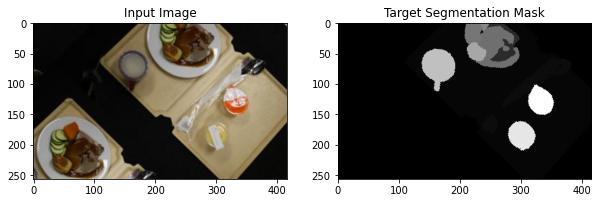

In [8]:
f, axes = plt.subplots(1, 2, figsize=(10, 10))

axes[0].imshow(load_img(train_img_paths[9]))
axes[0].set_title('Input Image')

# Display auto-contrast version of corresponding target (per-pixel categories)
axes[1].imshow(autocontrast(load_img(train_mask_paths[9])))
axes[1].set_title('Target Segmentation Mask')

plt.show()


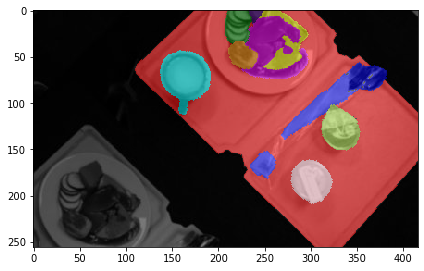

In [9]:
train_img = np.array(load_img(train_img_paths[9]))
# masked = io.imread(train_mask_paths[9])
label = np.array(load_img(train_mask_paths[9], color_mode="grayscale"))
 
io.imshow(color.label2rgb(label,train_img, alpha=0.5, bg_label=0))
plt.show()

# Image Generator

*   Create an image generator class (similar to the tutorial) to iterate over the images and return a tuple corresponding to the batch number.
*   The generator should inherit from the Sequence class.
*   It should have \_\_init\_\_(), \_\_len\_\_() and \_\_getitem\_\_() methods.
*   The batch size, image size, image paths and mask paths should be initialized using the \_\_init\_\_ method.

In [11]:
class ImageGenerator(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
            # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
        return x, y


# U-Net Xception-style model

*   We will use the same model architecture that we followed in the tutorial for this exercise

In [12]:
from tensorflow.keras import layers


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model
    

In [13]:
# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

In [14]:
# Build model

model = get_model(img_size, num_classes)

*   Print the summary of the model

In [15]:
# solution
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 80, 80, 32)   896         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 80, 80, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

# Instantiate Image Generators for each split

*   For this experiment, we will use the test split as the validation generator

In [16]:
random.Random(1337).shuffle(train_img_paths)
random.Random(1337).shuffle(train_mask_paths)

# Instantiate data Sequences for each split
train_gen = ImageGenerator(batch_size, img_size, train_img_paths, train_mask_paths)

val_gen = ImageGenerator(batch_size, img_size, test_img_paths, test_mask_paths)

# Train Model

*   Configure the model for training
    *   Use 'Sparse Categorical Crossentropy' loss for training
    *   Use 'rmsprop' optimizer

In [17]:
# solution
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy", "sparse_categorical_crossentropy"]) 

*   Instantiate a ModelCheckpoint callback to save only the best model

In [18]:
# solution
callbacks = [ keras.callbacks.ModelCheckpoint("Trayfood_segmentation.h5", 
                                              monitor='sparse_categorical_crossentropy',
                                              mode='auto',
                                              save_best_only=True)]

*   Train the model using fit method

In [19]:
# solution
# Train the model, doing validation at the end of each epoch.
epochs = 50
model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/50
39/39 [==============================] - ETA: 0s - loss: 2.1756 - accuracy: 0.5673 - sparse_categorical_crossentropy: 2.1756 

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


39/39 [==============================] - 1805s 46s/step - loss: 2.1756 - accuracy: 0.5673 - sparse_categorical_crossentropy: 2.1756
Epoch 2/50
39/39 [==============================] - 19s 473ms/step - loss: 1.2406 - accuracy: 0.5841 - sparse_categorical_crossentropy: 1.2406
Epoch 3/50
39/39 [==============================] - 19s 475ms/step - loss: 1.1467 - accuracy: 0.5864 - sparse_categorical_crossentropy: 1.1467
Epoch 4/50
39/39 [==============================] - 19s 476ms/step - loss: 1.1159 - accuracy: 0.5883 - sparse_categorical_crossentropy: 1.1159
Epoch 5/50
39/39 [==============================] - 19s 476ms/step - loss: 1.1049 - accuracy: 0.5819 - sparse_categorical_crossentropy: 1.1049
Epoch 6/50
39/39 [==============================] - 19s 477ms/step - loss: 1.0781 - accuracy: 0.5860 - sparse_categorical_crossentropy: 1.0781
Epoch 7/50
39/39 [==============================] - 19s 476ms/step - loss: 1.0539 - accuracy: 0.5871 - sparse_categorical_crossentropy: 1.0539
Epoch 8/50

In [20]:
# Save training model
model.save('/content/drive/MyDrive/model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/model/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


# Visualize predictions

*   Generate predictions for all images in the validation set

In [21]:
batch_size = 1  # we define batch_size as 1 for inferencing

val_gen = ImageGenerator(batch_size, img_size, test_img_paths, test_mask_paths)

In [22]:
# solution
val_preds = model.predict(val_gen)

*   The mask is determined by the maximum value along the final axis. For all the predictions get the value of the predicted mask.

In [23]:
# solution
val_masks = np.argmax(val_preds, axis=-1)
print("val_masks shape: ", val_masks.shape)

val_masks shape:  (8, 160, 160)


*   Read the test mask images to create the ground truth

In [24]:
jaccard_score

<function sklearn.metrics._classification.jaccard_score>

*   For each validation image, find the jaccard similarity score

In [25]:
for i in range(len(test_mask_paths)):
  g_t = img_as_int(resize(imread(test_mask_paths[i], as_gray=True), img_size))
  jac_score = jaccard_score(g_t.flatten(), val_masks[i].flatten(), average='micro')
  print(jac_score)

0.24945092488652448
0.25149715235511233
0.28185869510790645
0.22321236591251165
0.21143289797463563
0.2639790653467302
0.21942506013766166
0.24211547792333818


*   What do you understand from the 'average' parameter of the Jaccard similarity score function?
*   What are the different values of 'average' parameter? 
*   Which parameter is used for what type of problem?

**Solution**

The average parameter determines the type of averaging performed on the data

'binary':
Only report results for the class specified by pos_label. This is applicable only if targets (y_{true,pred}) are binary.

'micro':
Calculate metrics globally by counting the total true positives, false negatives and false positives.

'macro':
Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.

'weighted':
Calculate metrics for each label, and find their average, weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance.

'samples':
Calculate metrics for each instance, and find their average (only meaningful for multilabel classification).
...

*   Randomly display one image, groundtruth mask, overlayed groundtruth mask, prediction mask, overlayed prediction mask using matplotlib 

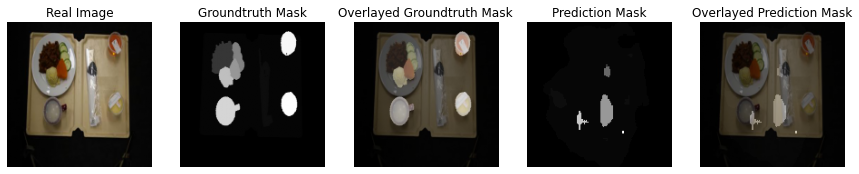

In [26]:
# solution
random.seed(888)
idx = random.randint(0, len(test_img_paths))
real_img = resize(imread(test_img_paths[idx]), img_size)
seg_mask = val_masks[idx]
ground_truth = resize(np.array(autocontrast(load_img(test_mask_paths[idx]))), img_size)

fig, axes =  plt.subplots(1, 5, figsize=(15, 10))

axes[0].imshow(real_img, cmap='gray')
axes[0].set_title('Real Image')
axes[0].axis('off')

axes[1].imshow(ground_truth, cmap='gray')
axes[1].set_title('Groundtruth Mask')
axes[1].axis('off')

axes[2].imshow(real_img) 
axes[2].imshow(ground_truth, alpha=0.5)
axes[2].set_title('Overlayed Groundtruth Mask')
axes[2].axis('off')

axes[3].imshow(seg_mask, cmap='gray')
axes[3].set_title('Prediction Mask')
axes[3].axis('off')



axes[4].imshow(real_img)
axes[4].imshow(seg_mask, alpha=0.5, cmap='gray')
axes[4].set_title('Overlayed Prediction Mask')
axes[4].axis('off')

plt.show()

(-0.5, 159.5, 159.5, -0.5)

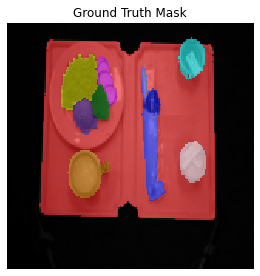

In [27]:
ground_truth = np.array(load_img(test_mask_paths[idx], target_size=img_size, color_mode="grayscale"))
real_img = np.array(real_img)
io.imshow(color.label2rgb(ground_truth, real_img, alpha=0.5, bg_label=0))
plt.title('Ground Truth Mask')
plt.axis('off')

(-0.5, 159.5, 159.5, -0.5)

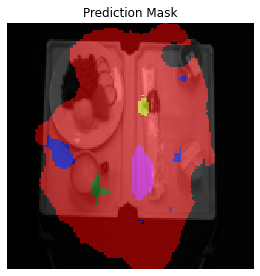

In [28]:
real_img = np.array(real_img)
seg_mask = np.array(seg_mask)  
io.imshow(color.label2rgb(seg_mask,real_img, alpha=0.5, bg_label=0))
plt.title('Prediction Mask')
plt.axis('off')

*   What are other evaluation metrics to compare the performance of segmentation?

**Solution**

1)Pixel Accuracy

2)Intersection-Over-Union (Jaccard Index)

3)Dice Coefficient (F1 Score)

A frequently used metric for evaluating segmentation performance is a DSC, corresponding to the F1 score, the harmonic average between precision and recall. It is a measure of overlap related to intersection over union between two sets X and Y, corresponding to the segmented pixels and the ground truth.
...

# Testing Model in the wild

*   Download 5 images from the internet similar to the dataset used.
*   Use the trained model to segment the images

In [44]:
# solution
imgs_dir = r'/content/drive/MyDrive/model/test_imgs'
paths = os.listdir(imgs_dir)
img_paths = []

for path in paths:
  file_path = os.path.join(imgs_dir, path)
  img_paths.append(file_path)  

In [ ]:
# !rm -rf '/content/drive/MyDrive/CV_lab52/test_imgs/.ipynb_checkpoints'

In [45]:
img_paths

['/content/drive/MyDrive/model/test_imgs/download.jfif',
 '/content/drive/MyDrive/model/test_imgs/download (3).jfif',
 '/content/drive/MyDrive/model/test_imgs/download (4).jfif',
 '/content/drive/MyDrive/model/test_imgs/download (2).jfif',
 '/content/drive/MyDrive/model/test_imgs/download (1).jfif']

In [46]:
test_gen = ImageGenerator(batch_size, img_size, img_paths, img_paths)

In [47]:
test_preds = model.predict(test_gen)

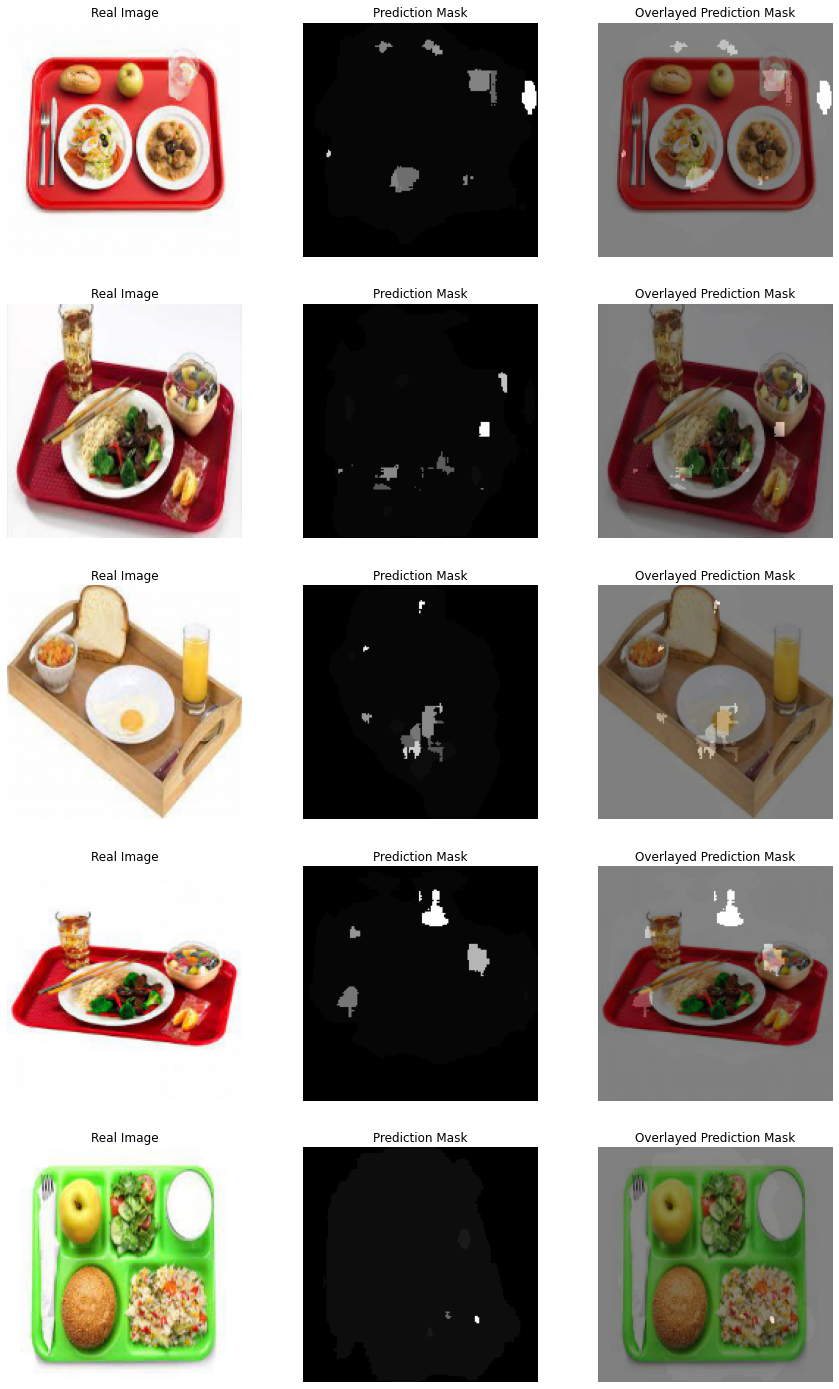

In [48]:
fig, axes = plt.subplots(5,3, figsize=(15,25))

for i in range(5):

  image = io.imread(img_paths[i])
  image = resize(image, img_size)
  axes[i][0].imshow(image)
  axes[i][0].set_title('Real Image')
  axes[i][0].axis('off')

  mask = np.argmax(test_preds[i], axis=-1)
  axes[i][1].imshow(mask, cmap='gray')
  axes[i][1].set_title('Prediction Mask')
  axes[i][1].axis('off')

  axes[i][2].imshow(image)
  axes[i][2].imshow(mask, cmap='gray', alpha=0.5)  
  axes[i][2].set_title('Overlayed Prediction Mask')
  axes[i][2].axis('off')

*   How accurate are the prediction masks?
*   What happens to the unlabelled classes?

**Solution**


The prediction masks are not accurate at all. This is because we have to well define the problem and the objectives:

If we only want to detect the image, it's a binary classification problem
If we want to localise the image approximatively (like a bounding box), it's an object detection problem and it can be realised with one or more classes.
If we want to localise precisely the image (in order to performe measures for instance) the best is semantic segmentation or instance segmentation.
If you want to classify the image, you will need to create classes for each defect you want to classify.

...

*   What are the challenges when you use a trained model in the wild?
*   How can you develop a model to be used in real world?

**Solution**

While using trained model in the wild we might get some exceptions because the classifier may not be able to account the features from multiple layers.

To develop a model which can be used in the wild may require to use a fully convolutional network in which the main idea is to supplement a usual contracting network by successive layers , where pooling operators are replaced by upsampling operators.
...

*   What is the difference between instance segmentation and semantic segmentation?

**Solution**


Semantic Segmentation – This involves detecting objects within an image and grouping them based on defined categories. For e.g. – In a street scene, you would draw boundaries and label items – Humans, Automobiles, Bikes, Traffic Lights, Walkway, Crossing, Lanes etc.  

Instance Segmentation – This takes semantic segmentation one step further and involves detecting objects within defined categories. For e.g. – In the same street scene, you would individually draw boundaries for each of the category and uniquely label – Humans – (Adult, Kid), Automobiles – (Cars, Bus, Motor Bikes…), and so on.

While Instance Segmentation labeling is expensive, it is one of the more robust and comprehensive methods of achieving object detection in the image analysis. Moreover, the application amplifies when assessing videos by analyzing individual frames in the video. There is real-intelligence to be tapped once you uniquely identify each instance of objects in an image which is segmented by defined categories.
...

*   What is the difference between encoder and decoder? Should they be of the same type of neural network?

**Solution**

An Encoder-Decoder architecture was developed where an input sequence was read in entirety and encoded to a fixed-length internal representation. A decoder network then used this internal representation to output words until the end of sequence token was reached.

The encoder usually is a pre-trained classification network like VGG/ResNet where you apply convolution blocks followed by a maxpool downsampling to encode the input image into feature representations at multiple different levels and
The task of the decoder is to semantically project the discriminative features (lower resolution) learnt by the encoder onto the pixel space (higher resolution) to get a dense classification.

...

*   What is upsampling?

**Solution**


Upsampling is the process of inserting zero-valued samples between original samples to increase the sampling rate.This kind of upsampling adds undesired spectral images to the original signal, which are centered on multiples of the original sampling rate.

Max pooling is a sampling strategy that picks the maximum value from a window. and upsampling is the reverse where each value can be surrounded with zeros to upsample the layer

...

*   What are feature channels in UNet? Why is this helpful in this architecture?

**Solution**


The feature channels simply mean the number of channels at a given point in the network. In the U-Net architecture, the number of channels doubles after the max pooling layers, see for example the first max pooling layer. The input is of size 568 by 568 pixels with 64 (feature) channels, after max pooling this becomes an array of size 284 by 284 pixels with the same 64 channels. The next convolutional layer then keeps the same size, so 284 by 284 pixels, but doubles the number of channels to 128.

...

*   What are some applications of U-Net?

**Solution**

Some applications of U-Net:

Microscopists: To study medical fields using multiple convolution layers

Pixel-wise regression using U-Net and its application on pansharpening.

3D U-Net: Learning Dense Volumetric Segmentation from Sparse Annotation.

TernausNet: U-Net with VGG11 Encoder Pre-Trained on ImageNet for Image Segmentation.

Image-to-image translation to estimate fluorescent stains
...


---

## **End of P5_2: Image Segmentation using UNet**
Deadline for P5_2 submission in CampusVirtual is: **Monday, the 3rd of January, 2022**